## Import

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.iolib.table import SimpleTable

## Read dataset

In [8]:
dataset = pd.read_csv("input/DailyDelhiClimateTrain.csv", index_col='date', dayfirst=True)
df = pd.DataFrame(dataset)
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [9]:
hum = dataset.humidity
hum.head()

date
2013-01-01    84.500000
2013-01-02    92.000000
2013-01-03    87.000000
2013-01-04    71.333333
2013-01-05    86.833333
Name: humidity, dtype: float64

<AxesSubplot:xlabel='date'>

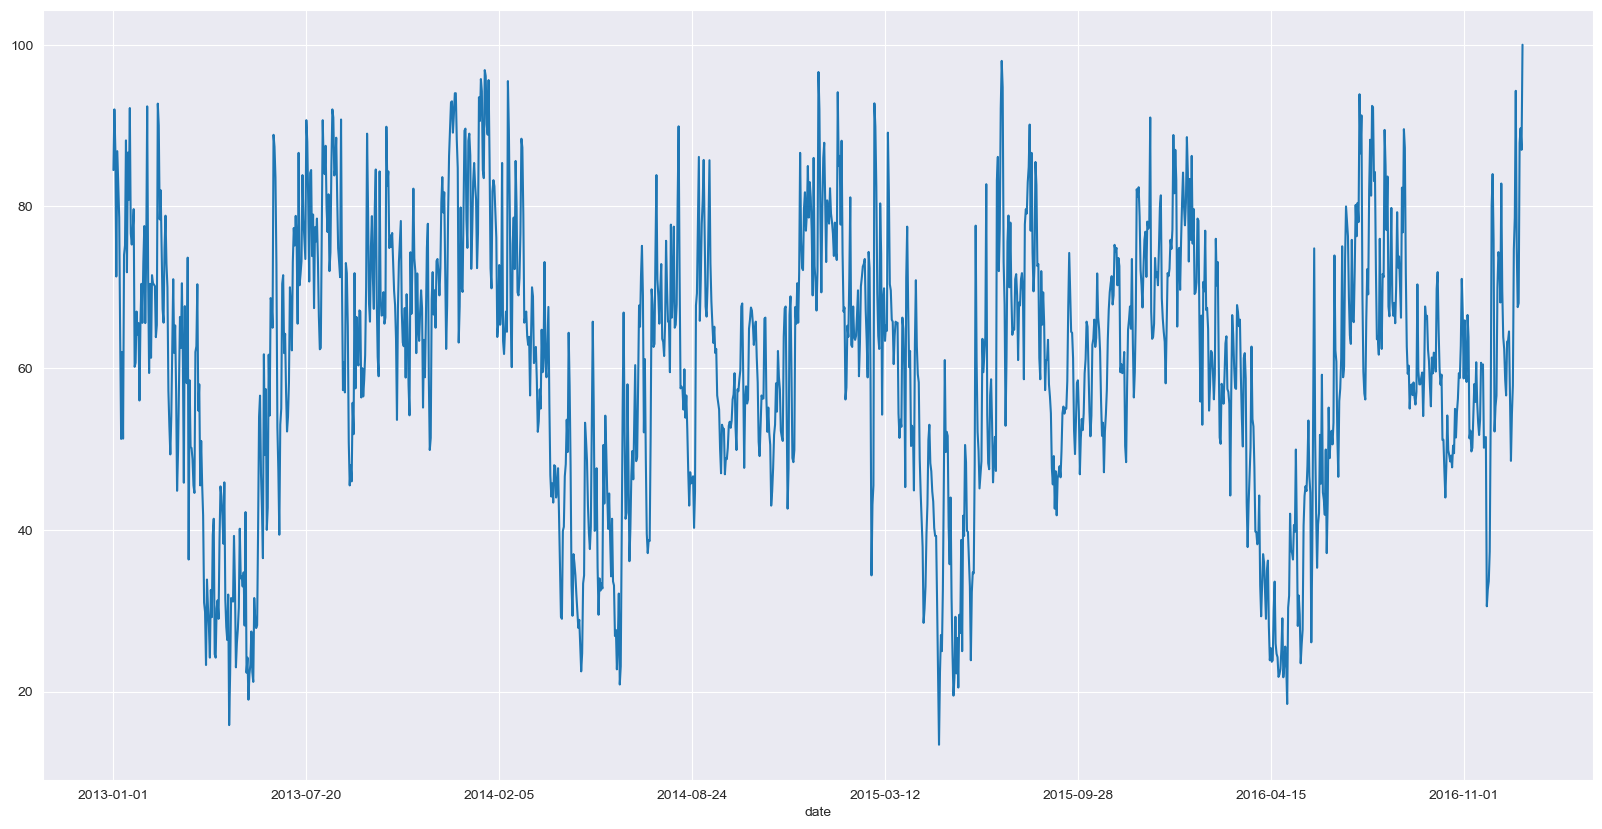

In [10]:
hum.plot(figsize=(20,10))

<bound method NDFrame.describe of date
2013-01-01     84.500000
2013-01-02     92.000000
2013-01-03     87.000000
2013-01-04     71.333333
2013-01-05     86.833333
                 ...    
2016-12-28     68.043478
2016-12-29     87.857143
2016-12-30     89.666667
2016-12-31     87.000000
2017-01-01    100.000000
Name: humidity, Length: 1462, dtype: float64>

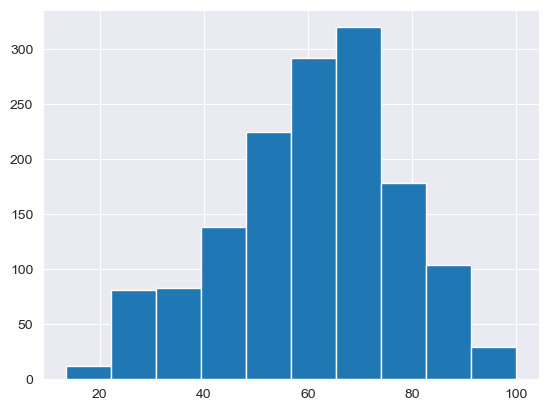

In [11]:
result = hum.describe
hum.hist()
result

In [12]:
row =  [u'JB', u'p-value', u'Skewness', u'Kurtosis']
jb_test = sm.stats.stattools.jarque_bera(hum)
a = np.vstack([jb_test])
testResult = SimpleTable(a, row)
print(testResult)

        JB               p-value               Skewness            Kurtosis    
-------------------------------------------------------------------------------
34.74158280413825 2.8573349132677248e-08 -0.34362423369234935 2.686946003245399
-------------------------------------------------------------------------------


In [13]:
test = sm.tsa.stattools.adfuller(hum)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -3.6755769191633383
p-value:  0.004470100478130771
Critical values:  {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}
единичных корней нет, ряд стационарен


## Count of duplicate and NaN values

In [14]:
dup = dataset.duplicated().sum()
print('Any Duplicate Value:',dup)
dataset.isnull().sum()

Any Duplicate Value: 0


meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [15]:
df_test = pd.read_csv("input/DailyDelhiClimateTrain.csv")

In [16]:
row = df_test["humidity"]
training_time_steps = 1000

/Users/pavelushakov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/pavelushakov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


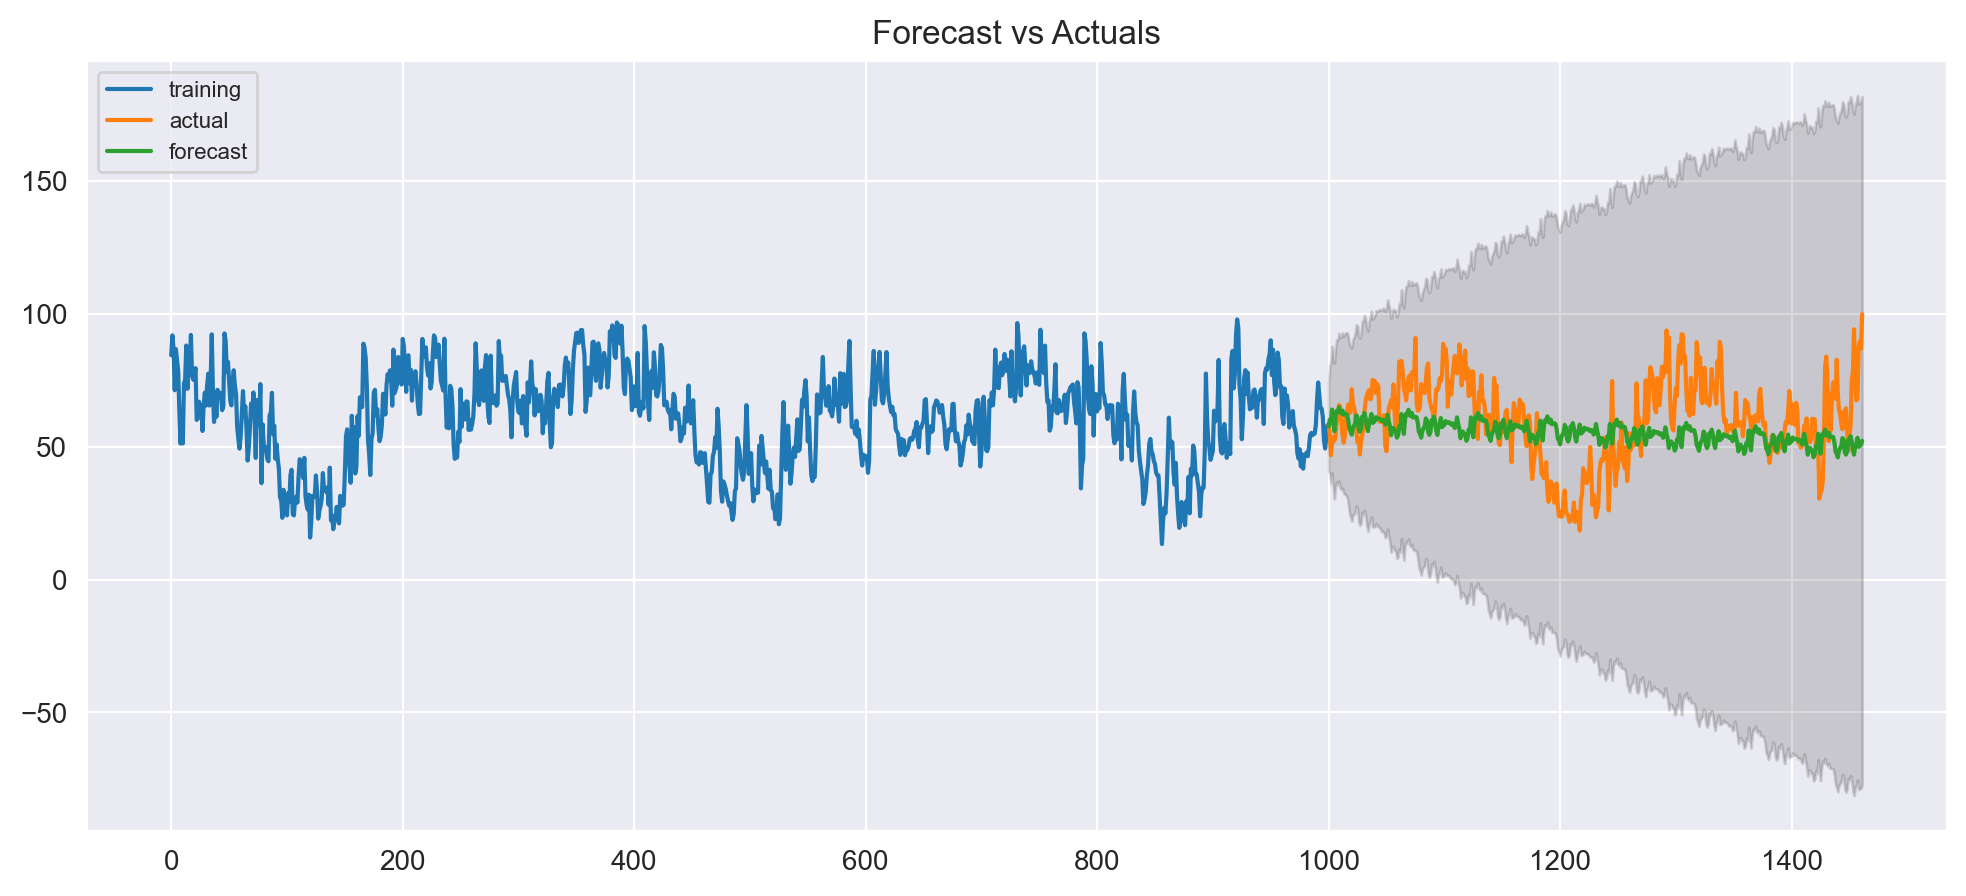

In [17]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(row[:training_time_steps], order=(1, 1, 1), seasonal_order=(1,1,1,60))
fitted = model.fit()

fc = fitted.get_forecast(len(row[training_time_steps:]))
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=row[training_time_steps:].index)
lower_series = pd.Series(conf.iloc[:, 0], index=row[training_time_steps:].index)
upper_series = pd.Series(conf.iloc[:, 1], index=row[training_time_steps:].index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(row[:training_time_steps], label='training')
plt.plot(row[training_time_steps:], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
sequence_length = 30
X = []
y = []
time_steps = len(row)
for i in range(time_steps - sequence_length):
    sequence = row[i:(i+sequence_length)]
    X.append(sequence)
    y.append(row[i+sequence_length])
X = np.array(X)
y = np.array(y)

In [19]:
import math
time_steps = len(X)
training_time_steps = math.floor(time_steps * 0.7)
X_train = X[:training_time_steps]
X_test = X[training_time_steps:]
y_train = y[:training_time_steps]
y_test = y[training_time_steps:]

X_train_sequences = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_sequences = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_anth = X.reshape(X.shape[0], 1, X.shape[1])

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, losses, metrics, optimizers

regressor = Sequential([layers.LSTM(units = 32, activation = 'relu', input_shape = (1, sequence_length)), layers.Dense(1)])

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from livelossplot import PlotLossesKerasTF
regressor.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
history = regressor.fit(X_train_sequences, y_train, batch_size=10, epochs=300, verbose=0, callbacks=[PlotLossesKerasTF()])

In [ ]:
y_predicted = regressor.predict(X_test_sequences)

In [ ]:
training_sequences = training_time_steps

In [ ]:
plt.figure(figsize=(12,5), dpi=200)
plt.plot(range(training_sequences), row[:training_sequences], label='training')
plt.plot(range(training_sequences, len(row)), row[training_sequences:], label='test')
plt.plot(range(1031,1461), y_predicted, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()